#### Imports

In [198]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import ttest_ind


%matplotlib inline


#### Exploration

In [155]:
PATH = './dataset/'
filename = 'cookie_cats.csv'

In [156]:
df = pd.read_csv(PATH + filename)

In [157]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [158]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [159]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [160]:
# unique users 
df['userid'].nunique()

90189

In [161]:
# unique users in each group 
df.groupby('version')['userid'].nunique()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

##### Distribution 

Text(0, 0.5, 'Number of users')

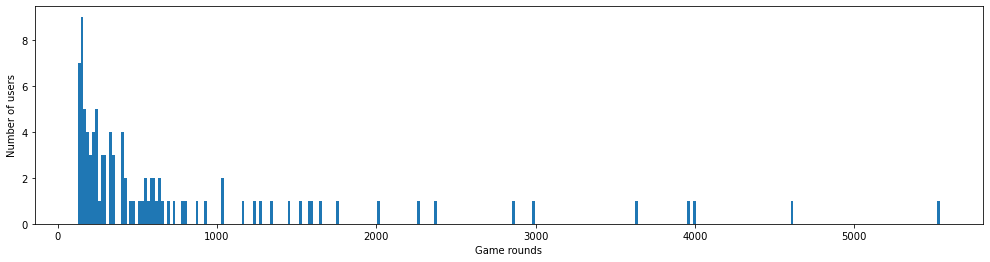

In [330]:
# distribution  by game rounds 
grounds_grouped = df.groupby('sum_gamerounds')['userid'].nunique()

# bin size
bins = np.sqrt(len(df))
bins = int(bins)

# plot the distribution of game rounds
ax = grounds_grouped.head(n=100).plot(x='sum_gamerounds', y='userid', kind='hist', bins= bins, figsize=(17,4))
ax.set_xlabel('Game rounds')
ax.set_ylabel('Number of users')

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

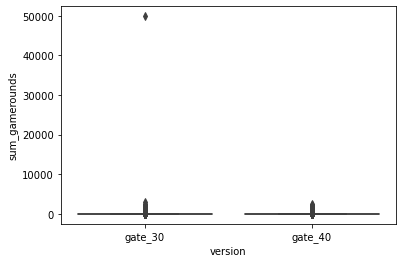

In [333]:
# game rounds and their outliers 
sns.boxplot(x = 'version', y = 'sum_gamerounds', data = df)

In [164]:
# removing outliers 
Q1 = df['sum_gamerounds'].quantile(0.25)
Q3 = df['sum_gamerounds'].quantile(0.75)
IQR = Q3 - Q1

# only keep rows in the DataFrame that are within the IQR
df = df[((df['sum_gamerounds'] > (Q1 - 1.5 * IQR)) | (df['sum_gamerounds'] < (Q3 + 1.5 * IQR)))]

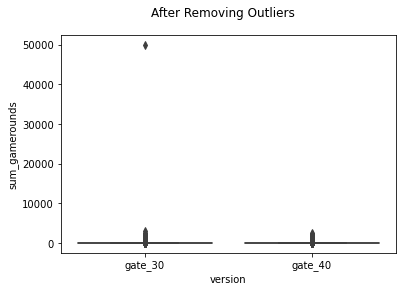

In [165]:
# game rounds and their outliers 
sns.boxplot(x = 'version', y = 'sum_gamerounds', data = df)
ax.set_xlabel('Game rounds')
plt.suptitle("After Removing Outliers");


##### Retention 

In [166]:
# baseline retention rate 
day_1_retention = df['retention_1'].sum() / df['retention_1'].count()

day_7_retention = df['retention_7'].sum()/ df['retention_7'].count()

print('Day 1 retention: {:.2f}%'.format(day_1_retention * 100))
print('Day 7 retention: {:.2f}%'.format(day_7_retention * 100))

Day 1 retention: 44.52%
Day 7 retention: 18.61%


In [167]:
# retention in each group 
retention_version_1 = df.groupby('version')['retention_1'].sum() / df.groupby('version')['retention_1'].count()
retention_version_7 = df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

print('The retention rate for day 1 in each version is: \n{}'.format(retention_version_1))
print('\nThe retention rate for day 7 in each version is: \n{}'.format(retention_version_7))


The retention rate for day 1 in each version is: 
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

The retention rate for day 7 in each version is: 
version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


<b>Observation</b>
There seems to be a very small drop in the retention for gate 40

##### Zooming in on day 1 retention
Investigating if positioning the gate at level 30 versus level 40 has an impact on the retention rate on the first day





<AxesSubplot:ylabel='Density'>

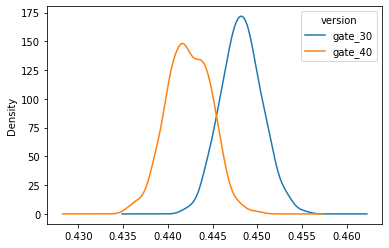

In [168]:
#  bootstrapping
# finding if there is a significant difference between the two AB-groups
bootstrap_1d = []

for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    bootstrap_1d.append(boot_mean)

bootstrap_1d = pd.DataFrame(bootstrap_1d)

# kde plot
bootstrap_1d.plot(kind='kde')

<b>Observation</b>
There seems to be a significant difference between the means

In [169]:
# confidence intervals
# Calculating the lower and upper 95% confidence intervals for each group
lower_bound = bootstrap_1d.quantile(0.025)
upper_bound = bootstrap_1d.quantile(0.975)

print("95% confidence intervals for each group:\n")
for group in bootstrap_1d.columns:
    print(f"{group}: ({lower_bound[group]}, {upper_bound[group]})")

95% confidence intervals for each group:

gate_30: (0.44408637658955324, 0.4528046174220255)
gate_40: (0.43757937379545003, 0.44681292221306723)


Text(0.5, 0, '% difference in means')

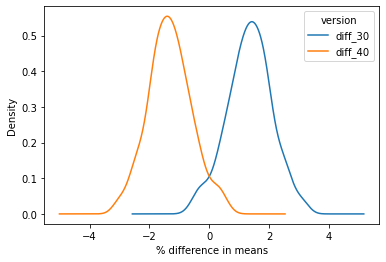

In [170]:
# computing the relative difference of the mean retention between the group 'gate_30' and the group 'gate_40'. 
# plotting the difference in means to find the magnitude of the difference
bootstrap_1d['diff_30'] = (bootstrap_1d['gate_30'] - bootstrap_1d['gate_40']) / bootstrap_1d['gate_40'] * 100
bootstrap_1d['diff_40'] = (bootstrap_1d['gate_40'] - bootstrap_1d['gate_30']) / bootstrap_1d['gate_30'] * 100

ax = bootstrap_1d[['diff_30','diff_40']].plot(kind='kde')
ax.set_xlabel("% difference in means")

<b>Observation</b> The difference favors gate 30

In [171]:
#  "probability of superiority" or "empirical probability" in the context of bootstrapping
# probability that 1-day retention is greater when the gate is at level 30
prob_day_1 = (bootstrap_1d['diff_30'] > 0).sum()/ len(bootstrap_1d['diff_30'])

print('Probability that 1-day retention is greater when the gate is at level 30: {:.2f}%'.format(prob_day_1 * 100))

Probability that 1-day retention is greater when the gate is at level 30: 95.00%


In [203]:
# adding robustness to the analysis by conducting a null hypothesis test
t_stat, p_value = ttest_ind(bootstrap_1d['gate_30'], bootstrap_1d['gate_40'])

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('Rejecting the null hypothesis that there is no difference between the two AB-groups')
else:
    print('Failing to reject the null hypothesis')

t-statistic: 39.62418126455866
p-value: 4.793665826019656e-207
Rejecting the null hypothesis that there is no difference between the two AB-groups


##### Zooming in on day 7 retention
Investigating if positioning the gate at level 30 versus level 40 has an impact on the retention rate on the 7th day





<AxesSubplot:ylabel='Density'>

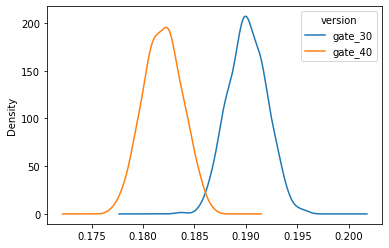

In [172]:
bootstrap_7d = []

for i in range(500):
    bootstrap_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    bootstrap_7d.append(bootstrap_mean)

bootstrap_7d = pd.DataFrame(bootstrap_7d)

# kde plot
bootstrap_7d.plot(kind='kde')

<b>Observation</b> Significant difference between the means 

In [173]:
# confidence intervals
# Calculating the lower and upper 95% confidence intervals for each group
lower_bound_ = bootstrap_7d.quantile(0.025)
upper_bound_ = bootstrap_7d.quantile(0.975)

print("95% confidence intervals for each group:\n")
for group in bootstrap_7d.columns:
    print(f"{group}: ({lower_bound_[group]}, {upper_bound_[group]})")

95% confidence intervals for each group:

gate_30: (0.18665603184031418, 0.1936323498852186)
gate_40: (0.17826344374341382, 0.18555650593019826)


Text(0.5, 0, '% difference in means')

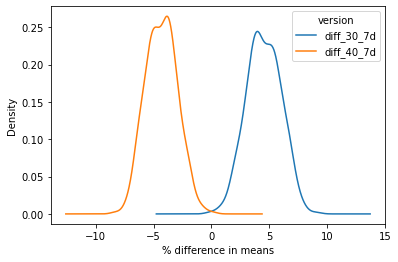

In [174]:
# computing the relative difference of the mean retention between the group 'gate_30' and the group 'gate_40'.
# plotting the difference in means to find the magnitude of the difference
bootstrap_7d['diff_30_7d'] = (bootstrap_7d['gate_30'] - bootstrap_7d['gate_40']) / bootstrap_7d['gate_40'] * 100
bootstrap_7d['diff_40_7d'] = (bootstrap_7d['gate_40'] - bootstrap_7d['gate_30']) / bootstrap_7d['gate_30'] * 100

ax = bootstrap_7d[['diff_30_7d','diff_40_7d']].plot(kind='kde')
ax.set_xlabel("% difference in means")

In [175]:
#  "probability of superiority" or "empirical probability" in the context of bootstrapping
# probability that 7-day retention is greater when the gate is at level 30

prob_day_7 = (bootstrap_7d['diff_30_7d'] > 0).sum()/ len(bootstrap_7d['diff_30_7d'])
print('Probability that 7-day retention is greater when the gate is at level 30: {:.2f}%'.format(prob_day_7 * 100))

Probability that 7-day retention is greater when the gate is at level 30: 99.80%


In [204]:
# adding robustness to the analysis by conducting a null hypothesis test
t_stat, p_value = ttest_ind(bootstrap_7d['gate_30'], bootstrap_7d['gate_40'])

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('Rejecting the null hypothesis that there is no difference between the two AB-groups')
else:
    print('Failing to reject the null hypothesis')

t-statistic: 69.73880401523374
p-value: 0.0
Rejecting the null hypothesis that there is no difference between the two AB-groups


In [176]:
# Should we move the gate from level 30 to level 40 ?
move_to_level_40 = False


#### Additional Analysis : 

##### Segmented Analysis
Checking to see if the gate placements had any effect on game rounds played 

In [234]:
df['gamerounds_segment'] = pd.cut(df['sum_gamerounds'], bins=[0, 10, 20, 30, 40, 50, 60,70,80,90, 100, 150, 200, 300, 400, 500, 5000])
segmented_retention_1 = df.groupby(['version', 'gamerounds_segment'])['retention_1'].mean()
segmented_retention_7 = df.groupby(['version', 'gamerounds_segment'])['retention_7'].mean()

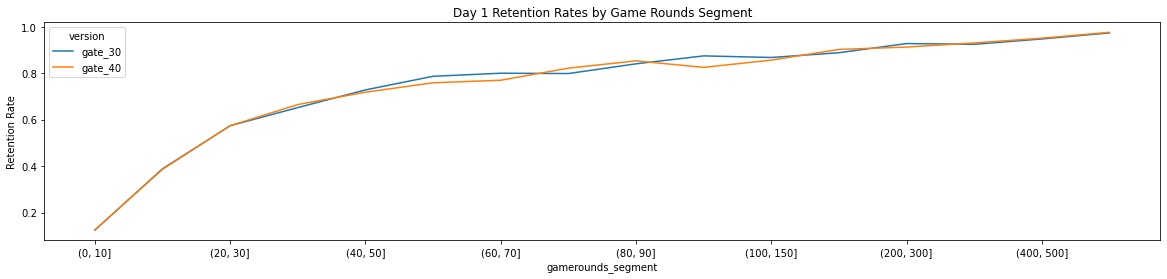

In [235]:

df.groupby(['version', 'gamerounds_segment'])['retention_1'].mean().unstack(0).plot(kind='line', figsize=(20,4))
plt.title('Day 1 Retention Rates by Game Rounds Segment')
plt.ylabel('Retention Rate')
plt.show()


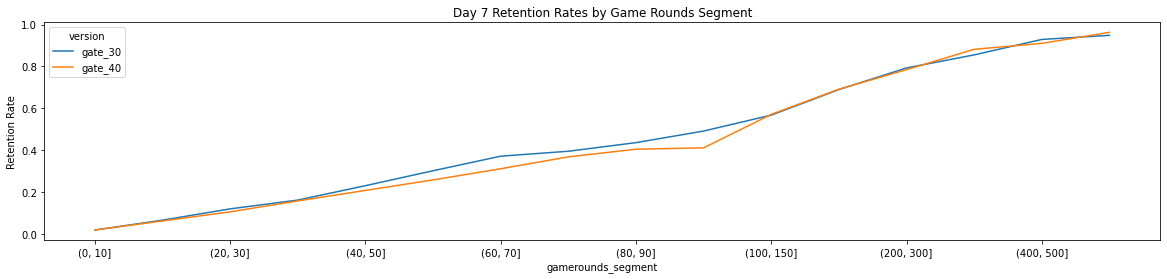

In [236]:

df.groupby(['version', 'gamerounds_segment'])['retention_7'].mean().unstack(0).plot(kind='line', figsize=(20,4))
plt.title('Day 7 Retention Rates by Game Rounds Segment')
plt.ylabel('Retention Rate')
plt.show()


In [268]:
# Loop over segments and perform t-test for both retention_1 and retention_7 to see which gamerounds had the biggest difference
for segment in df['gamerounds_segment'].unique():
    for retention_var in ['retention_1', 'retention_7']:
        segment_30 = df[(df['version'] == 'gate_30') & (df['gamerounds_segment'] == segment)][retention_var]
        segment_40 = df[(df['version'] == 'gate_40') & (df['gamerounds_segment'] == segment)][retention_var]
        t_stat, p_value = ttest_ind(segment_30, segment_40)

        if p_value < 0.05:
            print(f"For segment {segment} and {retention_var}, t-statistic: {t_stat}, p-value: {p_value}")


For segment (20.0, 30.0] and retention_7, t-statistic: 1.9705054397823216, p-value: 0.04881597381612547
For segment (50.0, 60.0] and retention_7, t-statistic: 2.739877022921219, p-value: 0.006180875692670964
For segment (90.0, 100.0] and retention_1, t-statistic: 2.5679629326971076, p-value: 0.010334896132338223
For segment (90.0, 100.0] and retention_7, t-statistic: 2.9923209665594515, p-value: 0.0028181083742778446
For segment (60.0, 70.0] and retention_7, t-statistic: 3.108074521427526, p-value: 0.0019051411680417643
